## Load Libraries

In [21]:
import numpy
from pandas import read_csv
import math
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

## convert an array of values into a dataset matrix

In [22]:
def create_dataset(dataset,look_back=1):
    dataX,dataY=[],[]
    for i in range(len(dataset)-look_back-1):
        a=dataset[i:(i+look_back),0]
        dataX.append(a)
        dataY.append(dataset[i+look_back,0])
    return numpy.array(dataX),numpy.array(dataY)
        

## load dataset

In [23]:
numpy.random.seed(7)
dataframe=read_csv("Desktop\\airline-passengers.csv",usecols=[1])
dataset=dataframe.values
dataset=dataset.astype('float32')

## normalize the dataset

In [24]:
scaler=MinMaxScaler(feature_range=(0,1))
dataset=scaler.fit_transform(dataset)

## split into train and test sets

In [25]:
train_size=int(len(dataset)*0.67)
test_size=len(dataset)-train_size
train,test=dataset[0:train_size,:],dataset[train_size:len(dataset),:]

## reshape into X=t and Y=t+1

In [26]:
look_back=3
trainX,trainY=create_dataset(train,look_back)
testX,testY=create_dataset(test,look_back)

## reshape input to be [samples, time steps, features]

In [27]:
trainX=numpy.reshape(trainX,(trainX.shape[0],trainX.shape[1],1))
testX=numpy.reshape(testX,(testX.shape[0],testX.shape[1],1))

The LSTM network has memory, which is capable of remembering across long sequences.

Normally, the state within the network is reset after each training batch when fitting the model, as well as each call to model.predict() or model.evaluate().

It requires that the training data not be shuffled when fitting the network. It also requires explicit resetting of the network state after each exposure to the training data (epoch) by calls to model.reset_states(). This means that we must create our own outer loop of epochs and within each epoch call model.fit() and model.reset_states().

Finally, when the LSTM layer is constructed, the stateful parameter must be set True and instead of specifying the input dimensions, we must hard code the number of samples in a batch, number of time steps in a sample and number of features in a time step by setting the batch_input_shape parameter.

## create and fit the LSTM network

In [28]:
batch_size = 1
model=Sequential()
model.add(LSTM(4,batch_input_shape=(batch_size,look_back,1),stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
for i in range(100):
    model.fit(trainX,trainY,epochs=1,batch_size=batch_size,verbose=2,shuffle=False)
    model.reset_states()

Epoch 1/1
 - 1s - loss: 0.0048
Epoch 1/1
 - 0s - loss: 0.0082
Epoch 1/1
 - 0s - loss: 0.0056
Epoch 1/1
 - 0s - loss: 0.0048
Epoch 1/1
 - 0s - loss: 0.0047
Epoch 1/1
 - 0s - loss: 0.0047
Epoch 1/1
 - 0s - loss: 0.0047
Epoch 1/1
 - 0s - loss: 0.0046
Epoch 1/1
 - 0s - loss: 0.0045
Epoch 1/1
 - 0s - loss: 0.0045
Epoch 1/1
 - 0s - loss: 0.0044
Epoch 1/1
 - 0s - loss: 0.0043
Epoch 1/1
 - 0s - loss: 0.0043
Epoch 1/1
 - 0s - loss: 0.0042
Epoch 1/1
 - 0s - loss: 0.0042
Epoch 1/1
 - 0s - loss: 0.0041
Epoch 1/1
 - 0s - loss: 0.0041
Epoch 1/1
 - 0s - loss: 0.0040
Epoch 1/1
 - 0s - loss: 0.0040
Epoch 1/1
 - 0s - loss: 0.0039
Epoch 1/1
 - 0s - loss: 0.0038
Epoch 1/1
 - 0s - loss: 0.0037
Epoch 1/1
 - 0s - loss: 0.0037
Epoch 1/1
 - 0s - loss: 0.0036
Epoch 1/1
 - 0s - loss: 0.0035
Epoch 1/1
 - 0s - loss: 0.0034
Epoch 1/1
 - 0s - loss: 0.0033
Epoch 1/1
 - 0s - loss: 0.0032
Epoch 1/1
 - 0s - loss: 0.0032
Epoch 1/1
 - 0s - loss: 0.0031
Epoch 1/1
 - 0s - loss: 0.0030
Epoch 1/1
 - 0s - loss: 0.0029
Epoch 1/

## make predictions

In [29]:
trainPredict=model.predict(trainX,batch_size=batch_size)
model.reset_states()
testPredict=model.predict(testX,batch_size=batch_size)
model.reset_states()

## invert predictions

In [30]:
trainPredict=scaler.inverse_transform(trainPredict)
trainY=scaler.inverse_transform([trainY])
testPredict=scaler.inverse_transform(testPredict)
testY=scaler.inverse_transform([testY])

## calculate root mean squared error

In [31]:
trainScore=math.sqrt(mean_squared_error(trainY[0],trainPredict[:,0]))
print("train score:",trainScore)
testScore=math.sqrt(mean_squared_error(testY[0],testPredict[:,0]))
print("test score :",testScore)

train score: 20.7944041290112
test score : 55.42099651816383


## plotting

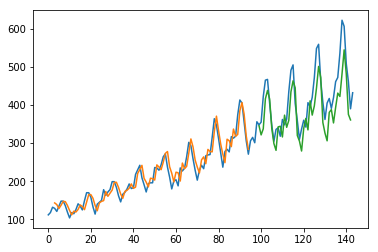

In [33]:
trainPredictPlot=numpy.empty_like(dataset)
trainPredictPlot[:,:]=numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back,:]=trainPredict

testPredictPlot=numpy.empty_like(dataset)
testPredictPlot[:,:]=numpy.nan
testPredictPlot[len(trainPredict)+(2*look_back)+1:len(dataset)-1,:]=testPredict

plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()